In [ ]:
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
#
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
#
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <https://www.gnu.org/licenses/>.

#     Written by Charalambos (Charis) Poullis - www.poullis.org

In [2]:
#Import all necessary libraries
import torch
import torchvision
import numpy as np
#progress bar functionality
import tqdm
#plotting etc
import matplotlib

import matplotlib.pyplot as plt
#random number generator
import random

# There is a weird crash in Python 3.9 causing the kernel to restart when using matplotlib
# To test if you have the same issue uncomment the following command. If it works, then you don't need the subsequent 2 lines (import os, KMP)
#plt.subplot()
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
#Set the path for the datasets
DATASET_PATH = "../data"

#The image size
CHANNELS = 3
WIDTH = 32
HEIGHT = 32

#Download the training dataset: CIFAR10
training_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                                train=True,
                                                download=True,
                                                transform=torchvision.transforms.ToTensor())
print('Training dataset:', training_dataset)

#Download the testing dataset: CIFAR10
testing_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                               train=False,
                                               download=True,
                                               transform=torchvision.transforms.ToTensor())
print('Testing dataset:', testing_dataset)  

#Create a list with user-friendly names for each label
labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Files already downloaded and verified
Testing dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
#This function takes a CIFAR dataset and splits it into two numpy arrays containing
#the images and labels, respectively

def splitDataset(dataset):
    #Divide the datasets into images and labels
    x, y = dataset[0]
    
    shape = [(i, *j) for i, j in [(len(dataset), x.shape)]][0]
    images = np.zeros(shape)
    labels = np.zeros((len(dataset), 1))
    
    for i in range(len(dataset)):
        x,y = dataset[i]
        images[i] = x
        labels[i] = y
        
    images = np.reshape(images, (len(dataset), 3, 32, 32))
    labels = np.reshape(labels, (len(dataset), 1))
    return images, labels

In [5]:
#Divide the training datasets into images and labels; this is needed later to randomly index from the arrays
training_images, training_labels = splitDataset(training_dataset)
#Do the same for the testing dataset
testing_images, testing_labels = splitDataset(testing_dataset)   

print(f'Training images: {len(training_images)}, Training labels: {len(training_labels)}')
print(f'Testing images: {len(testing_images)}, Testing labels: {len(testing_labels)}')

Training images: 50000, Training labels: 50000
Testing images: 10000, Testing labels: 10000


In [6]:
#Define the autoencoder; This is a simple autoencoder with 2 convolutional layers in the encoder, and 2 convolutional layers in the decoder
#Put simply, an autoencoder learns to reconstruct the input
class MyAutoencoder (torch.nn.Module):
    def __init__(self, channels, width, height):
        super(MyAutoencoder, self).__init__()

        #The image size info
        self.channels = channels
        self.width = width
        self.height = height

        #The latent dimensions
        self.latent_space_dims = 16

        #Define a unit Gaussian distribution to be used for sampling
        self.unit_gaussian_distribution = torch.distributions.normal.Normal(loc=torch.tensor(0.0).to(device),
                                                                            scale=torch.tensor(1.0).to(device))

        #The KL divergence
        self.KL_div = torch.tensor(0.0)
        
        #Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=0), #[batch_size, 16, 28, 28]
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, padding=0), #[batch_size, 8, 24, 24]
            torch.nn.ReLU()
        )

        #μ
        self.mu = torch.nn.Linear(in_features=8*24*24, out_features=self.latent_space_dims)
        #σ
        self.sigma = torch.nn.Linear(in_features=8*24*24, out_features=self.latent_space_dims)

        #Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=1, out_channels=16, kernel_size=11, padding=0), #[batch_size, 8, 14, 14]
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=11, padding=0), #[batch_size, 16, 24, 24]
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=9, padding=0), #[batch_size, 3, 32, 32]

            #At this point the range of the output value is unbound. Let's map the value to the range [0, 1]
            torch.nn.Sigmoid()
        )

        return

    def getKLdiv(self):
        return self.KL_div
    
    def forward(self, x):
        x = torch.reshape(x, (-1, self.channels, self.width, self.height))
        #Feed-forward through the encoder
        result = self.encoder(x)

        #Sample z using the Gaussian distribution
        result = torch.reshape(result, (-1, 8*24*24))
        mu = self.mu(result)
        sigma = torch.exp(self.sigma(result)) #self.sigma(.) can return negative values. We add the exponent to keep the values positive. Otherwise, what is the meaning of having negative standard deviation σ?
        z = mu + sigma*self.unit_gaussian_distribution.sample(mu.shape)

        #Feed-forward through the decoder
        z = torch.reshape(z, (-1, 1, 4, 4))
        result = self.decoder(z)
        result = torch.reshape(result, (-1, self.channels, self.width, self.height))
        #Calculate the closed form KL divergence between 2 Gaussians; you want the learnt (μ,σ) to resemble a zero-mean Gaussian distribution with standard deviation of 1.0
        self.KL_div = torch.sum(-torch.log(sigma) + mu**2 + sigma**2 - 0.5)

        return result

In [7]:
#We'll use GPU is available; check if a GPU is available
print(f'GPU devices found: {torch.cuda.device_count()}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

GPU devices found: 1
Device: cuda


In [8]:
#Create an instance of the model and print; it should display all the layers and their related information
model = MyAutoencoder(CHANNELS, WIDTH, HEIGHT).to(device)
print(model)

MyAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
  )
  (mu): Linear(in_features=4608, out_features=16, bias=True)
  (sigma): Linear(in_features=4608, out_features=16, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(1, 16, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(11, 11), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 3, kernel_size=(9, 9), stride=(1, 1))
    (5): Sigmoid()
  )
)


In [9]:
#SANITY CHECK: Feed forward an image and check for errors
#Pull the first image from the training images, and convert to a float tensor
img = torch.from_numpy(training_images[0]).float()
print(img.shape)

#The input to the autoencoder is [batch_size, 3, 32, 32]; convert the image's shape [3,32,32] to [1,3,32,32] and push to device
img = torch.reshape(img, (1, CHANNELS, WIDTH, HEIGHT)).to(device)

#feed forward the image to the network and make sure it works with no errors
model.forward(img)

torch.Size([3, 32, 32])


tensor([[[[0.4935, 0.4936, 0.4937,  ..., 0.4930, 0.4931, 0.4927],
          [0.4937, 0.4938, 0.4943,  ..., 0.4927, 0.4928, 0.4923],
          [0.4940, 0.4945, 0.4953,  ..., 0.4925, 0.4927, 0.4922],
          ...,
          [0.4932, 0.4929, 0.4931,  ..., 0.4925, 0.4930, 0.4932],
          [0.4933, 0.4930, 0.4932,  ..., 0.4919, 0.4926, 0.4929],
          [0.4933, 0.4929, 0.4930,  ..., 0.4924, 0.4928, 0.4929]],

         [[0.4905, 0.4905, 0.4902,  ..., 0.4917, 0.4912, 0.4906],
          [0.4905, 0.4906, 0.4900,  ..., 0.4916, 0.4908, 0.4907],
          [0.4906, 0.4904, 0.4900,  ..., 0.4913, 0.4906, 0.4905],
          ...,
          [0.4901, 0.4910, 0.4914,  ..., 0.4906, 0.4911, 0.4907],
          [0.4901, 0.4904, 0.4906,  ..., 0.4903, 0.4911, 0.4908],
          [0.4902, 0.4904, 0.4904,  ..., 0.4905, 0.4908, 0.4905]],

         [[0.5164, 0.5161, 0.5163,  ..., 0.5152, 0.5154, 0.5159],
          [0.5161, 0.5158, 0.5160,  ..., 0.5151, 0.5153, 0.5156],
          [0.5161, 0.5162, 0.5166,  ..., 0

In [10]:
#Switch to 0; otherwise it will load the saved weights
if 1:
    model.load_state_dict(torch.load("trained_weights_conv2d_CIFAR10.save"))
    model.eval()

In [12]:
#TRAINING

#define the hyperparameters
BATCH_SIZE = 100
EPOCHS=200
LEARNING_RATE=0.0000001


#Create an optimizer and pass the model's parameters
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

#Define a loss function; we'll pick mean squared error since we are reconstructing the original
loss_function = torch.nn.MSELoss(reduction='sum')

#training image indices; [0, 1, 2, 3 ....., 49999]
training_dataset_indices = torch.arange(0, len(training_dataset))

#keep track of the losses for plotting at the end
losses = list()

#Create a progress bar the size of the number of epochs
status_bar = tqdm.tqdm(range(EPOCHS), ncols=100, desc='loss: ')
for i in status_bar:
    #At each iteration, perform a permutation of the training_dataset_indices; this ensures that we will use all images and avoid duplication
    random_permutation = torch.randperm(training_dataset_indices.size()[0])

    #Get BATCH_SIZE number of training images at each epoch; because we sample from an array there will be no duplicates
    loss = None
    for b in range(0,training_dataset_indices.size()[0], BATCH_SIZE):
        #Zero out the gradients
        optimizer.zero_grad()

        #Get the indices of the training images in this batch
        batch_indices = random_permutation[b:b+BATCH_SIZE]
        #we only need to get the images; the labels are irrelevant in the context of an autoencoder
        batch_images = training_images[batch_indices]
        #convert to float tensors and push to device
        batch_images = torch.from_numpy(batch_images).float().to(device)

        #feed forward through the network's layers and get the reconstruction
        reconstructions = model.forward(batch_images)
        
        #Calculate the MSE between the reconstructions and the input images plus the KL divergence of the learnt distribution from a zero-mean Gaussian of standard deviation of 1.0; the optimal value for this loss is 0
        loss = loss_function(reconstructions, batch_images) + model.getKLdiv()

        #keep track of the losses per batch, per epoch it to the list; used for plotting later on
        losses.append(loss.item())
        
        #backpropagate gradients
        loss.backward()
        #single gradient descent step; update all network parameters based on the gradient
        optimizer.step()
    
    #After every epoch update the loss function
    status_bar.set_description(f'loss: {loss.item():.8f}')

#Output the final loss on the training dataset
print(f'Final loss on training: {loss.item():.8f}')

loss: 9334.04003906: 100%|████████████████████████████████████████████| 1/1 [00:07<00:00,  7.97s/it]

Final loss on training: 9334.04003906


In [13]:
#Switch to 0, otherwise it will overwrite the saved weights
if 0:
    torch.save(model.state_dict(), "trained_weights_conv2d_CIFAR10.save")

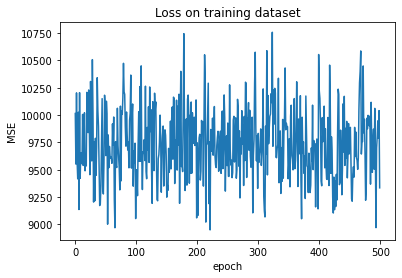

In [14]:
#Plot the loss as a function of epochs
fig, ax = plt.subplots(1,1)
ax.plot(list(range(EPOCHS*int(len(training_dataset)/BATCH_SIZE))), np.array(losses))
ax.set_title('Loss on training dataset')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE')
plt.show()
fig.savefig("vae_loss_conv2d_CIFAR10.png")

In [15]:
#Calculate MSE on the testing dataset; convert to float tensors and push to device; I'm passing all the images together since it fits in the GPU
testing_images_ = torch.from_numpy(testing_images[:BATCH_SIZE]).float().reshape( (BATCH_SIZE, 3, 32, 32) ).to(device)
#get the reconstructions
reconstructions = model.forward(testing_images_)
testing_loss = loss_function(reconstructions, testing_images_).item()
#Output the MSE loss
print(f'MSE loss on testing: {testing_loss:.8f}')

MSE loss on testing: 6840.71679688


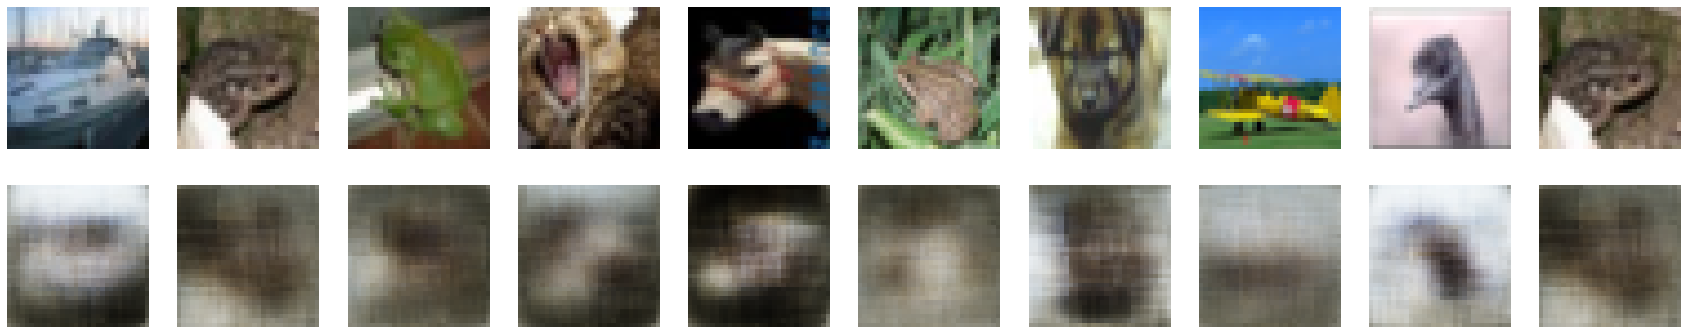

In [20]:
#Plot a couple of examples
cols, rows = 10, 2
image_counter = 1
figure = plt.figure(figsize=(3*cols, 3*rows))
for i in range(10):
    #get a random index
    rand_index = random.randint(0, len(testing_images_))
    #get the original image, pull back to cpu and convert to numpy
    original_img = testing_images_[rand_index].permute(1,2,0).cpu().detach().numpy()
    #get the reconstructed image, pull back to cpu and convert to numpy
    reconstructed_img = reconstructions[rand_index].permute(1,2,0).cpu().detach().numpy()
    
    #Add a figure for the original image
    figure.add_subplot(rows, cols, image_counter)
    plt.axis("off")
    plt.imshow(original_img)

    #Add a figure for the reconstructed image
    figure.add_subplot(rows, cols, image_counter+10)
    plt.axis("off")
    plt.imshow(reconstructed_img)
    image_counter+=1

plt.show()
figure.savefig("vae_reconstruction_conv2d_CIFAR10.png")